Create Your Own Smoothed-Particle-Hydrodynamics Simulation (With Python)
Philip Mocz (2020) Princeton Univeristy, @PMocz

Simulate the structure of a star with SPH

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma

Gausssian Smoothing kernel (3D)
- x     is a vector/matrix of x positions
- y     is a vector/matrix of y positions
- z     is a vector/matrix of z positions
- h     is the smoothing length
- w     is the evaluated smoothing function

In [2]:
def W(x, y, z, h):
    r = np.sqrt(x**2 + y**2 + z**2)
    w = (1.0 / (h * np.sqrt(np.pi))) ** 3 * np.exp(-(r**2) / h**2)
    return w

Gradient of the Gausssian Smoothing kernel (3D)
- x     is a vector/matrix of x positions
- y     is a vector/matrix of y positions
- z     is a vector/matrix of z positions
- h     is the smoothing length
- wx, wy, wz     is the evaluated gradient

In [3]:
def gradW(x, y, z, h):
    r = np.sqrt(x**2 + y**2 + z**2)

    n = -2 * np.exp(-(r**2) / h**2) / h**5 / (np.pi) ** (3 / 2)
    wx = n * x
    wy = n * y
    wz = n * z

    return wx, wy, wz

Get pairwise desprations between 2 sets of coordinates
- ri    is an M x 3 matrix of positions
- rj    is an N x 3 matrix of positions
- dx, dy, dz   are M x N matrices of separations

In [4]:
def getPairwiseSeparations(ri, rj):

    M = ri.shape[0]
    N = rj.shape[0]

    # positions ri = (x,y,z)
    rix = ri[:, 0].reshape((M, 1))
    riy = ri[:, 1].reshape((M, 1))
    riz = ri[:, 2].reshape((M, 1))

    # other set of points positions rj = (x,y,z)
    rjx = rj[:, 0].reshape((N, 1))
    rjy = rj[:, 1].reshape((N, 1))
    rjz = rj[:, 2].reshape((N, 1))

    # matrices that store all pairwise particle separations: r_i - r_j
    dx = rix - rjx.T
    dy = riy - rjy.T
    dz = riz - rjz.T

    return dx, dy, dz

Get Density at sampling loctions from SPH particle distribution
- r     is an M x 3 matrix of sampling locations
- pos   is an N x 3 matrix of SPH particle positions
- m     is the particle mass
- h     is the smoothing length
- rho   is M x 1 vector of densities

In [5]:
def getDensity(r, pos, m, h):
    M = r.shape[0]
    dx, dy, dz = getPairwiseSeparations(r, pos)
    rho = np.sum(m * W(dx, dy, dz, h), 1).reshape((M, 1))
    return rho

Equation of State
- rho   vector of densities
- k     equation of state constant
- n     polytropic index
- P     pressure

In [6]:
def getPressure(rho, k, n):
    P = k * rho ** (1 + 1 / n)
    return P

Calculate the acceleration on each SPH particle
- pos   is an N x 3 matrix of positions
- vel   is an N x 3 matrix of velocities
- m     is the particle mass
- h     is the smoothing length
- k     equation of state constant
- n     polytropic index
- mbda external force constant
- nu    viscosity
- a     is N x 3 matrix of accelerations

In [7]:
def getAcc(pos, vel, m, h, k, n, lmbda, nu):
    N = pos.shape[0]

    # Calculate densities at the position of the particles
    rho = getDensity(pos, pos, m, h)

    # Get the pressures
    P = getPressure(rho, k, n)

    # Get pairwise distances and gradients
    dx, dy, dz = getPairwiseSeparations(pos, pos)
    dWx, dWy, dWz = gradW(dx, dy, dz, h)

    # Add Pressure contribution to accelerations
    ax = -np.sum(m * (P / rho**2 + P.T / rho.T**2) * dWx, 1).reshape((N, 1))
    ay = -np.sum(m * (P / rho**2 + P.T / rho.T**2) * dWy, 1).reshape((N, 1))
    az = -np.sum(m * (P / rho**2 + P.T / rho.T**2) * dWz, 1).reshape((N, 1))

    # pack together the acceleration components
    a = np.hstack((ax, ay, az))

    # Add external potential force
    a -= lmbda * pos

    # Add viscosity
    a -= nu * vel

    return a

### SPH simulation

Simulation parameters


In [8]:
N = 400  # Number of particles
t = 0  # current time of the simulation
tEnd = 12  # time at which simulation ends
dt = 0.04  # timestep
M = 2  # star mass
R = 0.75  # star radius
h = 0.1  # smoothing length
k = 0.1  # equation of state constant
n = 1  # polytropic index
nu = 1  # damping
plotRealTime = True  # switch on for plotting as the simulation goes along

Generate Initial Conditions

In [9]:
# set the random number generator seed
np.random.seed(42)

# ~ 2.01
lmbda = (
    2
    * k
    * (1 + n)
    * np.pi ** (-3 / (2 * n))
    * (M * gamma(5 / 2 + n) / R**3 / gamma(1 + n)) ** (1 / n)
    / R**2
)

# single particle mass
m = M / N

# randomly selected positions and velocities
pos = np.random.randn(N, 3)
vel = np.zeros(pos.shape)


# calculate initial gravitational accelerations
acc = getAcc(pos, vel, m, h, k, n, lmbda, nu)

# number of timesteps
Nt = int(np.ceil(tEnd / dt))

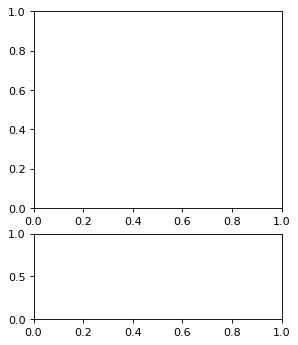

In [10]:
# prep figure
fig = plt.figure(figsize=(4, 5), dpi=80)
grid = plt.GridSpec(3, 1, wspace=0.0, hspace=0.3)
ax1 = plt.subplot(grid[0:2, 0])
ax2 = plt.subplot(grid[2, 0])
rr = np.zeros((100, 3))
rlin = np.linspace(0, 1, 100)
rr[:, 0] = rlin
rho_analytic = lmbda / (4 * k) * (R**2 - rlin**2)

### Simulation Main Loop

100%|█████████████████████████████████████████| 300/300 [00:42<00:00,  7.08it/s]


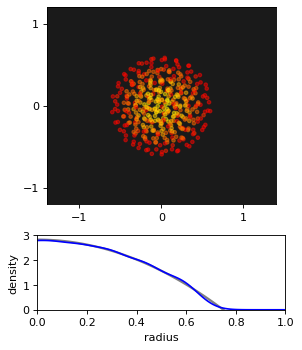

In [11]:
import imageio
from pathlib import Path
from tqdm import tqdm

save_path = Path("plots")
save_path.mkdir(exist_ok=True, parents=True)
plot_name = "gaussian"

for i in tqdm(range(Nt)):
    # (1/2) kick
    vel += acc * dt / 2

    # drift
    pos += vel * dt

    # update accelerations
    acc = getAcc(pos, vel, m, h, k, n, lmbda, nu)

    # (1/2) kick
    vel += acc * dt / 2

    # update time
    t += dt

    # get density for plotting
    rho = getDensity(pos, pos, m, h)

    # plot in real time
    if plotRealTime or (i == Nt - 1):
        plt.sca(ax1)
        plt.cla()
        cval = np.minimum((rho - 3) / 3, 1).flatten()
        plt.scatter(pos[:, 0], pos[:, 1], c=cval, cmap=plt.cm.autumn, s=10, alpha=0.5)
        ax1.set(xlim=(-1.4, 1.4), ylim=(-1.2, 1.2))
        ax1.set_aspect("equal", "box")
        ax1.set_xticks([-1, 0, 1])
        ax1.set_yticks([-1, 0, 1])
        ax1.set_facecolor("black")
        ax1.set_facecolor((0.1, 0.1, 0.1))

        plt.sca(ax2)
        plt.cla()
        ax2.set(xlim=(0, 1), ylim=(0, 3))
        ax2.set_aspect(0.1)
        plt.plot(rlin, rho_analytic, color="gray", linewidth=2)
        rho_radial = getDensity(rr, pos, m, h)
        plt.plot(rlin, rho_radial, color="blue")
        plt.savefig(save_path / (plot_name + f"{i}.png"), dpi=240)
        plt.close()

# add labels/legend
plt.sca(ax2)
plt.xlabel("radius")
plt.ylabel("density")

# Save figure
plt.savefig("sph.png", dpi=240)
plt.show()

In [12]:
import imageio.v2 as imageio

ims = [imageio.imread(save_path / (plot_name + f"{i}.png")) for i in range(Nt)]
imageio.mimwrite("output.gif", ims)